In [29]:
# 1. Installazioni necessarie per Colab
!pip install transformers[torch] textstat accelerate -U

In [30]:
!pip install -q transformers torch scikit-learn seaborn tqdm


In [31]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW # Moved AdamW import here

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", device)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

 Device: cuda
GPU: Tesla T4


In [32]:
df = pd.read_csv("ai_human_with_signatures.csv")

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["label_encoded"].value_counts())


Dataset shape: (500, 52)

Class distribution:
label_encoded
1    251
0    249
Name: count, dtype: int64


In [33]:
stylometric_features = [
    'sentence_length_cv', 'burstiness_index', 'pos_bigram_entropy',
    'dependency_depth_mean', 'lexical_compression_ratio',
    'function_word_ratio', 'sentence_similarity_drift',
    'structural_redundancy', 'sentiment_variance',
    'readability_oscillation', 'clause_density',
    'hapax_density', 'template_bias_score'
]

stylometric_features = [f for f in stylometric_features if f in df.columns]
print(f"Using {len(stylometric_features)} stylometric features")


Using 13 stylometric features


In [34]:
# Verifica che tutte le feature esistano
missing_features = [f for f in stylometric_features if f not in df.columns]
if missing_features:
    print(f" Missing features: {missing_features}")
    stylometric_features = [f for f in stylometric_features if f in df.columns]

print(f" Using {len(stylometric_features)} stylometric features\n")



 Using 13 stylometric features



In [35]:
print(df.columns)

Index(['topic', 'length_chars', 'length_words', 'quality_score', 'sentiment',
       'source_detail', 'plagiarism_score', 'notes', 'text_cleaned',
       'text_cleaned_lower', 'ai_pattern_count', 'text_cleaned_lem',
       'creation_year', 'creation_month', 'creation_dayofweek',
       'label_encoded', 'avg_word_length', 'lexical_diversity',
       'punctuation_density', 'exclamation_count', 'question_count',
       'hedge_words_count', 'intensifier_count', 'first_person_count',
       'sentence_count', 'type_token_ratio', 'avg_sentence_length',
       'readability_score', 'grade_level', 'entity_density',
       'person_entity_count', 'org_entity_count', 'location_entity_count',
       'total_entities', 'passive_voice_ratio', 'unique_bigram_ratio',
       'sentence_length_variability', 'contraction_density', 'leakage_flag',
       'sentence_length_cv', 'burstiness_index', 'pos_bigram_entropy',
       'dependency_depth_mean', 'lexical_compression_ratio',
       'function_word_ratio', 's

In [36]:
# Usiamo la versione lemmatizzata per una migliore analisi NLP
X_text = df["text_cleaned_lem"].fillna("").astype(str).values

# Tutte le tue feature stilometriche sono presenti nell'elenco!
X_feat = df[stylometric_features].values
y = df["label_encoded"].values

# Split dei dati (70% train, 15% val, 15% test)
from sklearn.model_selection import train_test_split

X_text_temp, X_text_test, X_feat_temp, X_feat_test, y_temp, y_test = train_test_split(
    X_text, X_feat, y, test_size=0.15, stratify=y, random_state=42
)

X_text_train, X_text_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_text_temp, X_feat_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)


print("Data Split:")
print(f"   Train: {len(y_train)} samples ({np.mean(y_train == 1):.1%} AI)")
print(f"   Val:   {len(y_val)} samples ({np.mean(y_val == 1):.1%} AI)")
print(f"   Test:  {len(y_test)} samples ({np.mean(y_test == 1):.1%} AI)\n")

Data Split:
   Train: 350 samples (50.0% AI)
   Val:   75 samples (50.7% AI)
   Test:  75 samples (50.7% AI)



In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sample_lengths = [len(tokenizer.encode(text, truncation=False)) for text in X_text_train[:1000]]
p90 = np.percentile(sample_lengths, 90)
print(f"📏 Text length analysis (90th percentile): {int(p90)} tokens")
MAX_LENGTH = min(512, max(128, int(p90)))  # Cap at 512, min 128
print(f"   Using MAX_LENGTH = {MAX_LENGTH}\n")

📏 Text length analysis (90th percentile): 30 tokens
   Using MAX_LENGTH = 128



In [38]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [39]:
print("=" * 70)
print(" MODEL 1: BERT FINE-TUNED")
print("=" * 70)

model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

print(f" BERT loaded: {sum(p.numel() for p in model_bert.parameters()):,} parameters\n")

# Create datasets
train_dataset = TextDataset(X_text_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_text_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_text_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

 MODEL 1: BERT FINE-TUNED


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT loaded: 109,483,778 parameters



In [40]:
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)


# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [41]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch['labels'].numpy())
    return np.array(predictions), np.array(true_labels)


In [42]:
# Training loop
print("Training BERT...")
best_val_acc = 0
for epoch in range(epochs):
    print(f"\n📍 Epoch {epoch + 1}/{epochs}")
    avg_loss = train_epoch(model_bert, train_loader, optimizer, scheduler, device)
    print(f"   Train loss: {avg_loss:.4f}")

    # Validation
    val_preds, val_labels = evaluate(model_bert, val_loader, device)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"   Val accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_bert.state_dict(), 'best_bert.pth')
        print(f" Best model saved!")

# Load best model and evaluate on test
model_bert.load_state_dict(torch.load('best_bert.pth'))
y_pred_bert, _ = evaluate(model_bert, test_loader, device)

acc = accuracy_score(y_test, y_pred_bert)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')

print(f"\nBERT Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}\n")



Training BERT...

📍 Epoch 1/3


Training: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]


   Train loss: 0.5060


   Val accuracy: 0.9600
 Best model saved!

📍 Epoch 2/3


Training: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]


   Train loss: 0.1291


   Val accuracy: 1.0000
 Best model saved!

📍 Epoch 3/3


Training: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]


   Train loss: 0.0370


   Val accuracy: 1.0000



BERT Test Performance:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000



In [43]:
# ============================================================================
# 5. HYBRID MODEL (BERT + Stylometric Features)
# ============================================================================

print("=" * 70)
print(" MODEL 2: HYBRID (BERT + Stylometric)")
print("=" * 70)

def get_bert_embeddings(texts, model, tokenizer, device, max_length, batch_size=16):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(
                list(batch),
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            outputs = model.bert(
                input_ids=encoded['input_ids'].to(device),
                attention_mask=encoded['attention_mask'].to(device)
            )
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

print(" Extracting BERT embeddings...")
bert_train = get_bert_embeddings(X_text_train, model_bert, tokenizer, device, MAX_LENGTH)
bert_val = get_bert_embeddings(X_text_val, model_bert, tokenizer, device, MAX_LENGTH)
bert_test = get_bert_embeddings(X_text_test, model_bert, tokenizer, device, MAX_LENGTH)


 MODEL 2: HYBRID (BERT + Stylometric)
 Extracting BERT embeddings...


Extracting embeddings: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


In [44]:
# Scala feature stilometriche
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_val_scaled = scaler.transform(X_feat_val)
X_feat_test_scaled = scaler.transform(X_feat_test)

# Combine features
X_hybrid_train = np.hstack([bert_train, X_feat_train_scaled])
X_hybrid_val = np.hstack([bert_val, X_feat_val_scaled])
X_hybrid_test = np.hstack([bert_test, X_feat_test_scaled])

print(f" Hybrid shape: {X_hybrid_train.shape}")
print(f"   BERT: {bert_train.shape[1]} dims | Stylometric: {X_feat_train_scaled.shape[1]} dims\n")


 Hybrid shape: (350, 781)
   BERT: 768 dims | Stylometric: 13 dims



In [45]:
# Train Random Forest su hybrid features
print("Training Random Forest...")
rf_hybrid = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_hybrid.fit(X_hybrid_train, y_train)

y_pred_hybrid = rf_hybrid.predict(X_hybrid_test)
y_proba_hybrid = rf_hybrid.predict_proba(X_hybrid_test)[:, 1]

acc = accuracy_score(y_test, y_pred_hybrid)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')
auc = roc_auc_score(y_test, y_proba_hybrid)

print(f"\n Hybrid Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

Training Random Forest...

 Hybrid Test Performance:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   ROC-AUC:   1.0000



In [46]:
print("=" * 70)
print(" MODEL 3: BASELINE (Stylometric Only)")
print("=" * 70)

rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_feat_train_scaled, y_train)

y_pred_baseline = rf_baseline.predict(X_feat_test_scaled)
y_proba_baseline = rf_baseline.predict_proba(X_feat_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred_baseline)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')
auc = roc_auc_score(y_test, y_proba_baseline)

print(f"\n Baseline Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

 MODEL 3: BASELINE (Stylometric Only)

 Baseline Test Performance:
   Accuracy:  0.8133
   Precision: 0.8219
   Recall:    0.8133
   F1-Score:  0.8123
   ROC-AUC:   0.9225



In [47]:
# Feature importance
importances = rf_baseline.feature_importances_
feature_ranking = pd.DataFrame({
    'feature': stylometric_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Stylometric Features:")
print(feature_ranking.head(5).to_string(index=False))
print()

Top 5 Most Important Stylometric Features:
                  feature  importance
    dependency_depth_mean    0.292186
       pos_bigram_entropy    0.188679
      function_word_ratio    0.173621
           clause_density    0.079744
sentence_similarity_drift    0.043023



 MODEL COMPARISON
                Model  Accuracy  F1-Score
      BERT Fine-tuned  1.000000  1.000000
  Hybrid (BERT+Style)  1.000000  1.000000
Baseline (Style Only)  0.813333  0.812333

✅ Visualization saved: 'model_comparison.png'



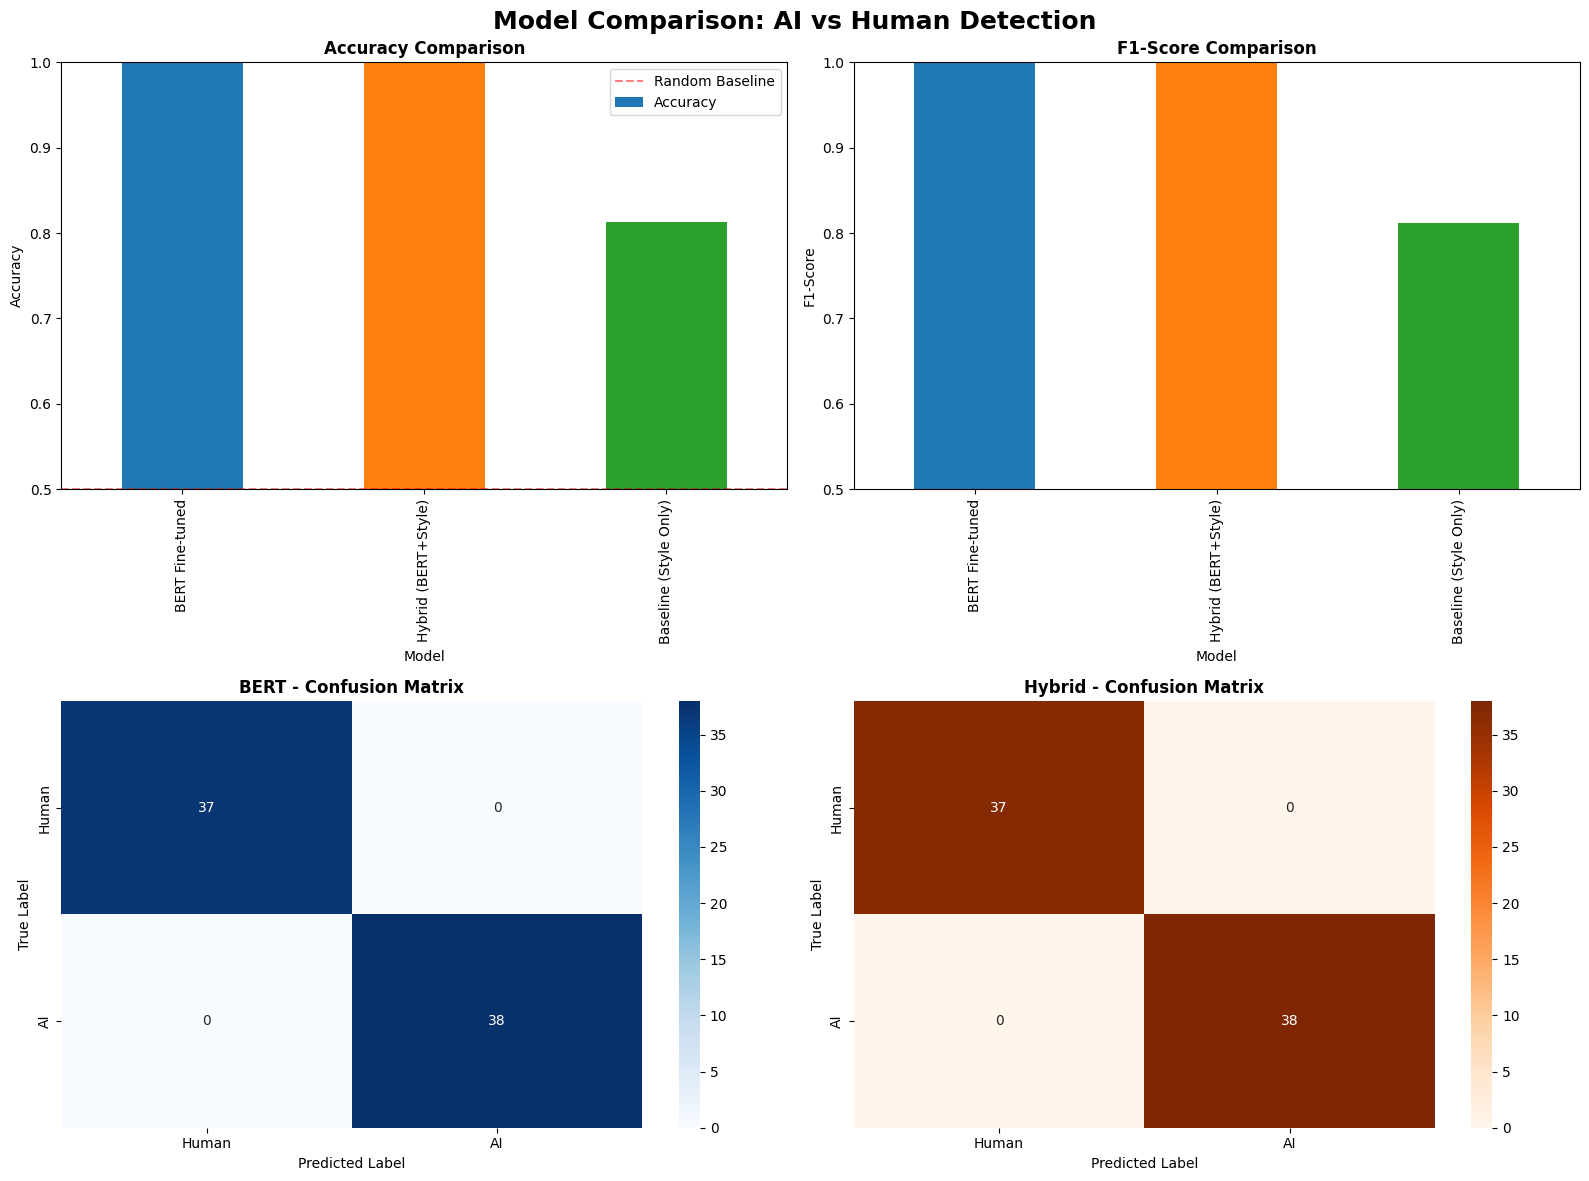

In [48]:
print("=" * 70)
print(" MODEL COMPARISON")
print("=" * 70)

# Crea DataFrame comparativo
results = pd.DataFrame({
    'Model': ['BERT Fine-tuned', 'Hybrid (BERT+Style)', 'Baseline (Style Only)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_bert),
        accuracy_score(y_test, y_pred_hybrid),
        accuracy_score(y_test, y_pred_baseline)
    ],
    'F1-Score': [
        precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')[2]
    ]
})

print(results.to_string(index=False))
print()

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparison: AI vs Human Detection', fontsize=18, fontweight='bold')

# Plot 1: Accuracy Comparison
ax = axes[0, 0]
results.plot(x='Model', y='Accuracy', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('Accuracy Comparison', fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1.0])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax.legend()

# Plot 2: F1-Score Comparison
ax = axes[0, 1]
results.plot(x='Model', y='F1-Score', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('F1-Score Comparison', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0.5, 1.0])

# Plot 3: Confusion Matrix - BERT
ax = axes[1, 0]
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('BERT - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Plot 4: Confusion Matrix - Hybrid
ax = axes[1, 1]
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Oranges', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('Hybrid - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved: 'model_comparison.png'\n")



In [49]:
import joblib

In [50]:
import joblib
import os

print("=" * 70)
print(" SAVING MODELS IN STRUCTURED FOLDERS")
print("=" * 70)

# 1. Creazione delle cartelle se non esistono
for folder in ['pkl', 'pth', 'txt', 'bert_ai_detector']:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 2. Salvataggio modelli BERT (PTH e Config)
# Nota: save_pretrained salva i pesi .bin/.safetensors e i file config nella cartella specificata
model_bert.save_pretrained('./bert_ai_detector')
tokenizer.save_pretrained('./bert_ai_detector')
# Salviamo anche il file .pth esplicitamente nella cartella pth per tua comodità
torch.save(model_bert.state_dict(), os.path.join('pth', 'best_bert_final.pth'))

# 3. Salvataggio modelli Scikit-Learn (PKL)
joblib.dump(rf_hybrid, os.path.join('pkl', 'rf_hybrid_model.pkl'))
joblib.dump(rf_baseline, os.path.join('pkl', 'rf_baseline_model.pkl'))
joblib.dump(scaler, os.path.join('pkl', 'feature_scaler.pkl'))
joblib.dump(config, os.path.join('pkl', 'model_config.pkl'))

# 4. Salvataggio documentazione e feature list (TXT)
with open(os.path.join('txt', 'stylometric_features.txt'), 'w') as f:
    f.write('\n'.join(stylometric_features))

# Aggiungiamo un piccolo report testuale dei risultati
with open(os.path.join('txt', 'training_results_summary.txt'), 'w') as f:
    f.write(results.to_string(index=False))

print(" All models saved successfully in their respective folders!")
print(f" 📂 [pkl/]: RF models, Scaler, and Config")
print(f" 📂 [pth/]: PyTorch model state dicts")
print(f" 📂 [txt/]: Feature list and Results summary")
print(f" 📂 [bert_ai_detector/]: Full BERT model for HuggingFace-style loading")

 SAVING MODELS IN STRUCTURED FOLDERS
 All models saved successfully in their respective folders!
 📂 [pkl/]: RF models, Scaler, and Config
 📂 [pth/]: PyTorch model state dicts
 📂 [txt/]: Feature list and Results summary
 📂 [bert_ai_detector/]: Full BERT model for HuggingFace-style loading
